<a href="https://colab.research.google.com/github/Harshith-VC/Twitter-sentiment-Extaction-Analysis/blob/main/Twitter_Sentiment_Extaction_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re
import string
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [ ]:
ss=pd.read_csv("/content/sample_submission.csv")
test =pd.read_csv("/content/test.csv")
train=pd.read_csv("/content/train.csv")

In [ ]:
print(train.shape)
print(test.shape)
print(ss.shape)

(27481, 4)
(3534, 3)
(3534, 2)


So We have 27486 tweets in the train set and 3535 tweets in the test set

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


We have one null Value in the train , as the test field for value is NAN we will just remove it

In [ ]:
train.dropna(inplace=True)

**Exploratory Data Analysis**

In [ ]:
train.head(3)

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_word_text,difference_in_words,temp_list,temp_list1
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral,1.000000,7,7,0,"[id, responded, going]","[id, responded, going]"
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative,0.200000,2,10,8,"[sooo, sad]","[sooo, sad, miss, san, diego]"
2,088c60f138,my boss is bullying me,bullying me,negative,0.166667,2,5,3,[bullying],"[boss, bullying]"


In [ ]:
train.describe()

,textID,text,selected_text,sentiment
count,27480,27480,27480,27480
unique,27480,27480,22463,3
top,cb774db0d1,"I`d have responded, if I were going",good,neutral
freq,1,1,199,11117


Lets look at the distribution of tweets in the train set

In [ ]:
def random_colours(number_of_colors):
    '''
    Simple function for random colours generation.
    Input:
        number_of_colors - integer value indicating the number of colours which are going to be generated.
    Output:
        Color in the following format: ['#E86DA4'] .
    '''
    colors = []
    for i in range(number_of_colors):
        colors.append("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
    return colors

In [ ]:
temp = train.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Paired')

,sentiment,text
1,neutral,11117
2,positive,8582
0,negative,7781


<Axes: xlabel='sentiment', ylabel='count'>

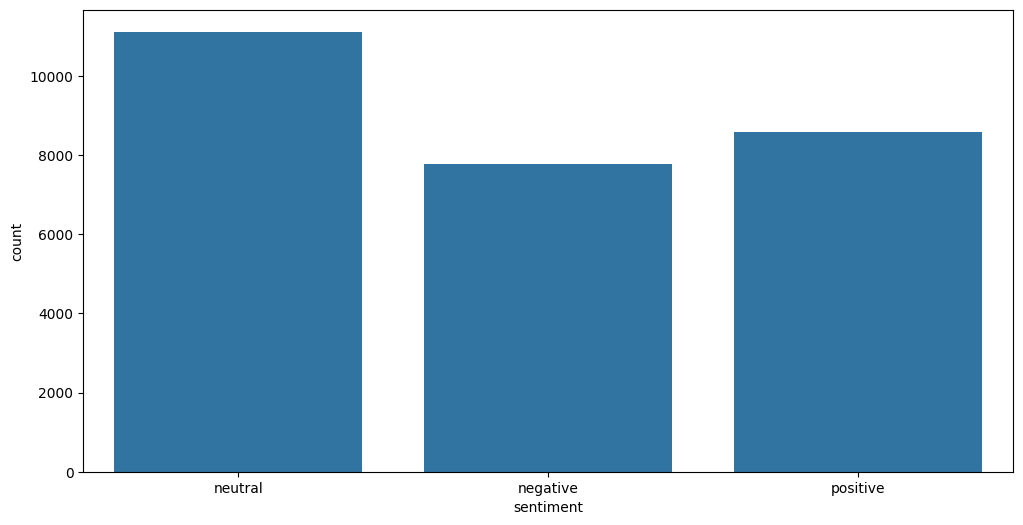

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=train)

Let's draw a Funnel-Chart for better visualization

In [ ]:
fig = go.Figure(go.Funnelarea(
    text =temp.sentiment,
    values = temp.text,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

### What We Already Know About Our Data:

Before we begin, let's review some key points about our data that will help us gain new insights:

1. **Selected Text as a Subset:**
   - We know that the `selected_text` is always a subset of the `text` column.

2. **Consistency in Selected Text:**
   - The `selected_text` contains only one continuous segment of the text. It does not jump between sentences. For example, if the text is:
     - `"Spent the entire morning in a meeting w/ a vendor, and my boss was not happy w/ them. Lots of fun. I had other plans for my morning."`
     - The `selected_text` can be `"my boss was not happy w/ them. Lots of fun"` or just `"Lots of fun"`, but not something like `"Morning, vendor, and my boss."`


### Generating Meta-Features

In previous versions of this notebook, We focused on using the number of words in the `selected_text` and the main `text`, as well as the length of words in both `text` and `selected_text` as primary meta-features. However, given the nature of this competition, where the goal is to predict the `selected_text` as a subset of the main `text`, more relevant and useful features to generate would include:

1. **Difference in Number of Words:**
   - The difference in the number of words between `selected_text` and the main `text`. This feature helps quantify how much of the text is being selected.

2. **Jaccard Similarity Scores:**
   - The Jaccard similarity score between `text` and `selected_text`. This score measures the overlap between the two texts, providing insight into how similar the selected portion is to the entire text.

These features should provide more meaningful insights and improve the model's ability to predict the `selected_text`.

In [ ]:
def jaccard(str1, str2):
    a = set(str1.lower().split())
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [ ]:
results_jaccard=[]

for ind,row in train.iterrows():
    sentence1 = row.text
    sentence2 = row.selected_text

    jaccard_score = jaccard(sentence1,sentence2)
    results_jaccard.append([sentence1,sentence2,jaccard_score])

In [ ]:
jaccard = pd.DataFrame(results_jaccard,columns=["text","selected_text","jaccard_score"])
train = train.merge(jaccard,how='outer')

In [ ]:
train['Num_words_ST'] = train['selected_text'].apply(lambda x:len(str(x).split())) #Number Of words in Selected Text
train['Num_word_text'] = train['text'].apply(lambda x:len(str(x).split())) #Number Of words in main text
train['difference_in_words'] = train['Num_word_text'] - train['Num_words_ST'] #Difference in Number of words text and Selected Text

In [ ]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_word_text,difference_in_words
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1.000000,7,7,0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0.200000,2,10,8
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,2,5,3
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,3,5,2
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0.214286,3,14,11


Let's look at the distribution of Meta-Features

In [ ]:
hist_data = [train['Num_words_ST'],train['Num_word_text']]

group_labels = ['Selected_Text', 'Text']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels,show_curve=False)
fig.update_layout(title_text='Distribution of Number Of words')
fig.update_layout(
    autosize=False,
    width=900,
    height=700,
    paper_bgcolor="LightSteelBlue",
)
fig.show()

The number of words plot is really interesting ,the tweets having number of words greater than 25 are very less and thus the number of words distribution plot is right skewed

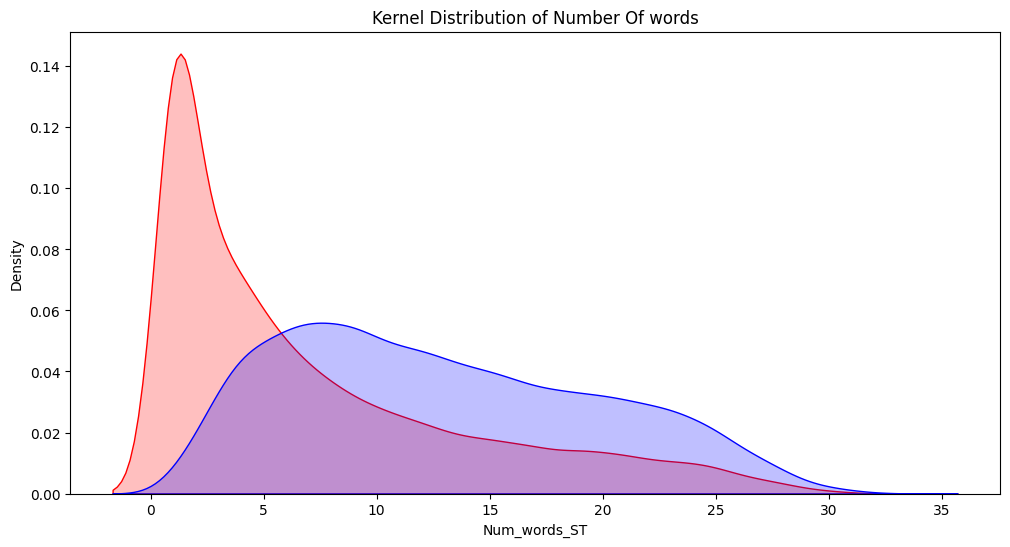

In [ ]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train['Num_words_ST'], shade=True, color="r").set_title('Kernel Distribution of Number Of words')
p1=sns.kdeplot(train['Num_word_text'], shade=True, color="b")

Now It will be more interesting to see the differnce in number of words and jaccard_scores across different Sentiments

In [ ]:
import plotly.figure_factory as ff

# Prepare the data
positive_data = train[train['sentiment'] == 'positive']['difference_in_words']
negative_data = train[train['sentiment'] == 'negative']['difference_in_words']

# Create a distplot
fig = ff.create_distplot(
    [positive_data, negative_data],
    group_labels=['Positive Sentiment', 'Negative Sentiment'],
    colors=['blue', 'red'],
    show_hist=False,
    show_rug=False
)

# Update layout
fig.update_layout(
    title='Kernel Distribution of Difference in Number Of Words',
    xaxis_title='Difference in Words',
    yaxis_title='Density',
    width=900,
    height=600,
    paper_bgcolor="LightSteelBlue",
    plot_bgcolor="white",
)

# Show the figure
fig.show()


<Axes: xlabel='difference_in_words'>

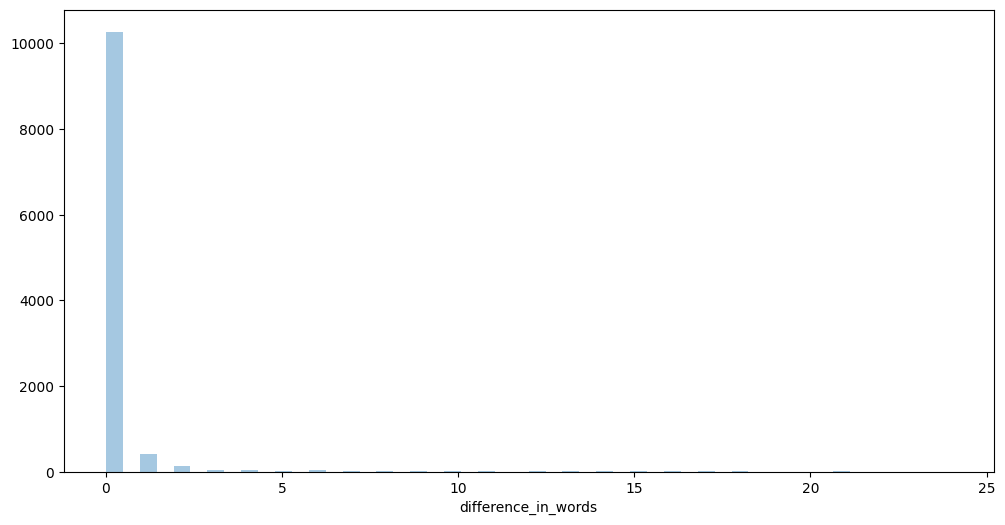

In [ ]:
plt.figure(figsize=(12,6))
sns.distplot(train[train['sentiment']=='neutral']['difference_in_words'],kde=False)

 We can see it clearly now ,if we had used the feature in the starting we would have known that text and selected text are mostly the same for neutral tweets,thus its always important to keep the end goal in mind while performing EDA

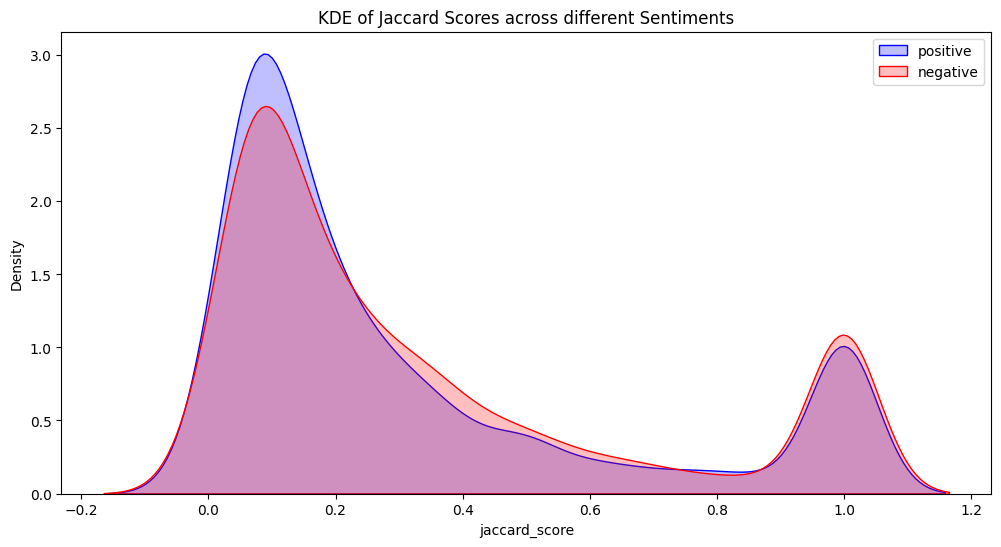

In [ ]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train[train['sentiment']=='positive']['jaccard_score'], shade=True, color="b").set_title('KDE of Jaccard Scores across different Sentiments')
p2=sns.kdeplot(train[train['sentiment']=='negative']['jaccard_score'], shade=True, color="r")
plt.legend(labels=['positive','negative'])

<Axes: xlabel='jaccard_score'>

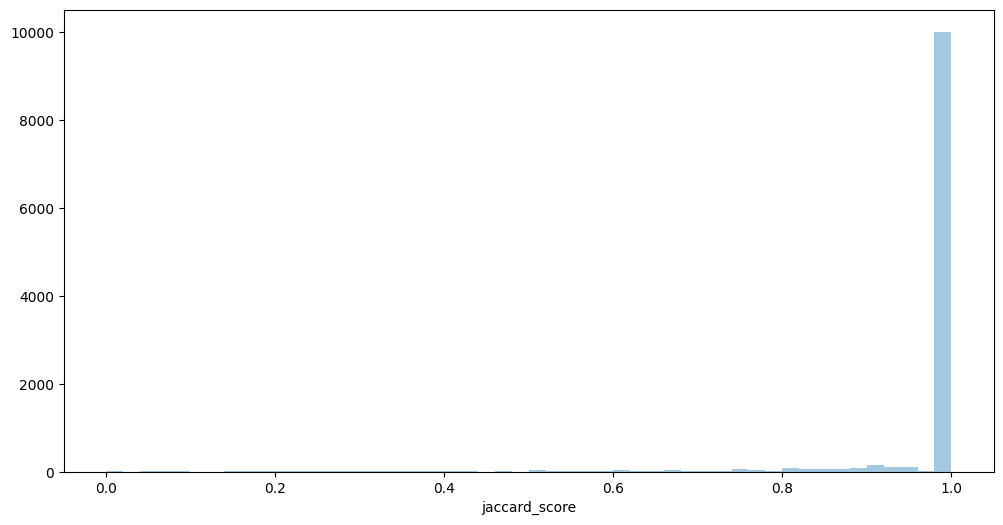

In [ ]:
plt.figure(figsize=(12,6))
sns.distplot(train[train['sentiment']=='neutral']['jaccard_score'],kde=False)


### Analysis Summary:

- **Positive and negative tweets** show high kurtosis, meaning their values are tightly concentrated in narrow, high-density regions.
- **Neutral tweets** have low kurtosis, with a noticeable increase in density near a value of 1.

### Explanation for those unfamiliar:

- **Kurtosis** measures how peaked a distribution is and how spread out the values are around that peak.
- **Skewness** indicates how much a curve deviates from a normal distribution.

### Conclusion from EDA:

- The Jaccard score plot shows a peak around 1 for both positive and negative tweets. This suggests a cluster of tweets with high similarity between the main text and selected texts. If we can identify these clusters, we may be able to predict the selected text for those tweets, regardless of the segment.
- One idea for finding these clusters is to focus on tweets with fewer than three words, as these might have texts that are fully used as selected texts.



In [ ]:
k = train[train['Num_word_text']<=2]
k.head()

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_word_text,difference_in_words
7,50e14c0bb8,Soooo high,Soooo high,neutral,1.0,2,2,0
26,852edc3769,I`m sorry.,I`m sorry.,negative,1.0,2,2,0
42,2e7082d1c8,MAYDAY?!,MAYDAY?!,neutral,1.0,1,1,0
61,a4b0888da6,haha yes,haha yes,neutral,1.0,2,2,0
68,fa2654e730,Chilliin,Chilliin,positive,1.0,1,1,0


In [ ]:
# Convert to integer
k['jaccard_score'] = k['jaccard_score'].astype(int)

In [ ]:
k.groupby("sentiment")['jaccard_score'].mean()

,jaccard_score
sentiment,
negative,0.629630
neutral,0.970944
positive,0.594203


We can see that there is similarity between text and selected text .Let's have closer look

In [ ]:
k[k['sentiment']=='positive']

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_word_text,difference_in_words
68,fa2654e730,Chilliin,Chilliin,positive,1,1,1,0
80,bbbc46889b,THANK YYYYYYYYYOOOOOOOOOOUUUUU!,THANK YYYYYYYYYOOOOOOOOOOUUUUU!,positive,1,2,2,0
170,f3d95b57b1,good morning,good morning,positive,1,2,2,0
278,89d5b3f0b5,Thanks,Thanks,positive,1,1,1,0
429,a78ef3e0d0,Goodmorning,Goodmorning,positive,1,1,1,0
...,...,...,...,...,...,...,...,...
26689,e80c242d6a,Goodnight;,Goodnight;,positive,1,1,1,0
26725,aad244f37d,*hug*,*hug*,positive,1,1,1,0
26842,a46571fe12,congrats!,congrats!,positive,1,1,1,0
26959,49a942e9b1,Happy birthday.,Happy birthday.,positive,1,2,2,0


Thus its clear that most of the times , text is used as selected text.We can improve this by preprocessing the text which have word length less than 3.We will remember this information and use it in model building

Cleaning the Corpus
Now Before We Dive into extracting information out of words in text and selected text,let's first clean the data

In [ ]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
train['text'] = train['text'].apply(lambda x:clean_text(x))
train['selected_text'] = train['selected_text'].apply(lambda x:clean_text(x))

In [ ]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_word_text,difference_in_words
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral,1.000000,7,7,0
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative,0.200000,2,10,8
2,088c60f138,my boss is bullying me,bullying me,negative,0.166667,2,5,3
3,9642c003ef,what interview leave me alone,leave me alone,negative,0.600000,3,5,2
4,358bd9e861,sons of why couldnt they put them on the rel...,sons of,negative,0.214286,3,14,11


Most Common words in our Target-Selected Text¶

In [ ]:
train['temp_list'] = train['selected_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,i,7200
1,to,5305
2,the,4590
3,a,3538
4,my,2783
5,you,2624
6,and,2321
7,it,2158
8,is,2115
9,in,1986


In [ ]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Selected Text', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

OOPS!While we cleaned our dataset we didnt remove the stop words and hence we can see the most coomon word is 'to' . Let's try again after removing the stopwords

In [ ]:
import nltk
from nltk.corpus import stopwords

# Step 1: Download the stopwords corpus
nltk.download('stopwords')

# Step 2: Define the function to remove stopwords
def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('english')]

# Step 3: Apply the function to your DataFrame
train['temp_list'] = train['temp_list'].apply(lambda x: remove_stopword(x))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

,Common_words,count
1,good,1251
2,day,1058
3,love,909
4,happy,852
5,like,774
6,get,772
7,dont,765
8,go,700
9,cant,613
10,work,612


In [ ]:
fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree of Most Common Words')
fig.show()

**Most Common words in Text**

Let's also look at the most common words in Text

In [ ]:
train['temp_list1'] = train['text'].apply(lambda x:str(x).split()) #List of words in every row for text
train['temp_list1'] = train['temp_list1'].apply(lambda x:remove_stopword(x)) #Removing Stopwords

In [ ]:
top = Counter([item for sublist in train['temp_list1'] for item in sublist])
temp = pd.DataFrame(top.most_common(25))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
1,day,2044
2,good,1549
3,get,1426
4,like,1346
5,go,1267
6,dont,1200
7,love,1122
8,work,1112
9,going,1096
10,today,1096


In [ ]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Text', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

SO we can see the Most common words in Selected text and Text are almost the same,which was obvious



**Most common words Sentiments Wise**

Let's look at the most common words in different sentiments

In [ ]:
Positive_sent = train[train['sentiment']=='positive']
Negative_sent = train[train['sentiment']=='negative']
Neutral_sent = train[train['sentiment']=='neutral']

In [ ]:
#MosT common positive words
top = Counter([item for sublist in Positive_sent['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,good,826
1,happy,730
2,love,697
3,day,456
4,thanks,439
5,great,364
6,fun,287
7,nice,267
8,mothers,259
9,hope,245


In [ ]:
fig = px.bar(temp_positive, x="count", y="Common_words", title='Most Commmon Positive Words', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

In [ ]:
#MosT common negative words
top = Counter([item for sublist in Negative_sent['temp_list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

,Common_words,count
1,miss,358
2,sad,343
3,sorry,300
4,bad,246
5,hate,230
6,dont,221
7,cant,201
8,sick,166
9,like,162
10,sucks,159


In [ ]:
fig = px.treemap(temp_negative, path=['Common_words'], values='count',title='Tree Of Most Common Negative Words')
fig.show()

In [ ]:
#MosT common Neutral words
top = Counter([item for sublist in Neutral_sent['temp_list'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(20))
temp_neutral = temp_neutral.loc[1:,:]
temp_neutral.columns = ['Common_words','count']
temp_neutral.style.background_gradient(cmap='Reds')

,Common_words,count
1,get,612
2,go,569
3,day,492
4,dont,482
5,going,472
6,work,467
7,like,445
8,got,441
9,today,427
10,lol,427


In [ ]:
fig = px.bar(temp_neutral, x="count", y="Common_words", title='Most Commmon Neutral Words', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

In [ ]:
fig = px.treemap(temp_neutral, path=['Common_words'], values='count',title='Tree Of Most Common Neutral Words')
fig.show()


We notice that words like "get," "go," "don't," "got," "u," "can't," "lol," and "like" are common across all three segments. This is interesting because words like "don't" and "can't" typically have a negative tone, while "lol" has a more positive tone. This raises the question of whether our data might be incorrectly labeled. We’ll gain more insights into this after conducting an N-gram analysis.

It will also be intriguing to explore the unique words associated with different sentiments.

### Let's Examine Unique Words in Each Segment:
We will look at the unique words in the following order:

1. Positive
2. Negative
3. Neutral



In [ ]:
raw_text = [word for word_list in train['temp_list1'] for word in word_list]

In [ ]:
def words_unique(sentiment,numwords,raw_words):
    '''
    Input:
        segment - Segment category (ex. 'Neutral');
        numwords - how many specific words do you want to see in the final result;
        raw_words - list  for item in train_data[train_data.segments == segments]['temp_list1']:
    Output:
        dataframe giving information about the name of the specific ingredient and how many times it occurs in the chosen cuisine (in descending order based on their counts)..

    '''
    allother = []
    for item in train[train.sentiment != sentiment]['temp_list1']:
        for word in item:
            allother .append(word)
    allother  = list(set(allother ))

    specificnonly = [x for x in raw_text if x not in allother]

    mycounter = Counter()

    for item in train[train.sentiment == sentiment]['temp_list1']:
        for word in item:
            mycounter[word] += 1
    keep = list(specificnonly)

    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]

    Unique_words = pd.DataFrame(mycounter.most_common(numwords), columns = ['words','count'])

    return Unique_words

Positive Tweets

In [ ]:
Unique_Positive= words_unique('positive', 20, raw_text)
print("The top 20 unique words in Positive Tweets are:")
Unique_Positive.style.background_gradient(cmap='Greens')

The top 20 unique words in Positive Tweets are:


,words,count
0,congratulations,29
1,thnx,10
2,appreciated,8
3,shared,7
4,presents,7
5,greetings,7
6,blessings,6
7,mothersday,6
8,mcr,6
9,coolest,6


In [ ]:
fig = px.treemap(Unique_Positive, path=['words'], values='count',title='Tree Of Unique Positive Words')
fig.show()

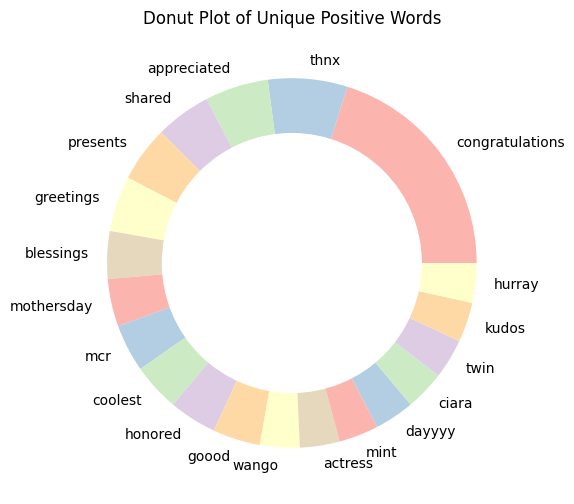

In [ ]:

!pip install palettable

from palettable.colorbrewer.qualitative import Pastel1_7
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
my_circle = plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_Positive['count'], labels=Unique_Positive.words, colors=Pastel1_7.hex_colors)
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Donut Plot of Unique Positive Words')
plt.show()


In [ ]:
Unique_Negative= words_unique('negative', 10, raw_text)
print("The top 10 unique words in Negative Tweets are:")
Unique_Negative.style.background_gradient(cmap='Reds')

The top 10 unique words in Negative Tweets are:


,words,count
0,ache,12
1,suffering,9
2,allergic,7
3,cramps,7
4,saddest,7
5,pissing,7
6,sob,6
7,dealing,6
8,devastated,6
9,noes,6


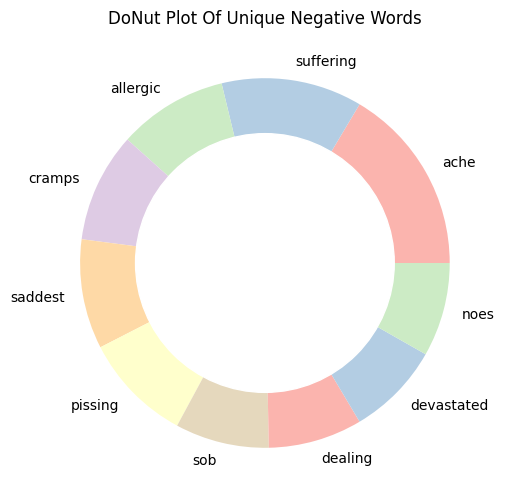

In [ ]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(6,6))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.rcParams['text.color'] = 'black'
plt.pie(Unique_Negative['count'], labels=Unique_Negative.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Negative Words')
plt.show()

In [ ]:
Unique_Neutral= words_unique('neutral', 10, raw_text)
print("The top 10 unique words in Neutral Tweets are:")
Unique_Neutral.style.background_gradient(cmap='Oranges')

The top 10 unique words in Neutral Tweets are:


,words,count
0,settings,9
1,explain,7
2,mite,6
3,hiya,6
4,reader,5
5,pr,5
6,sorta,5
7,fathers,5
8,enterprise,5
9,guessed,5


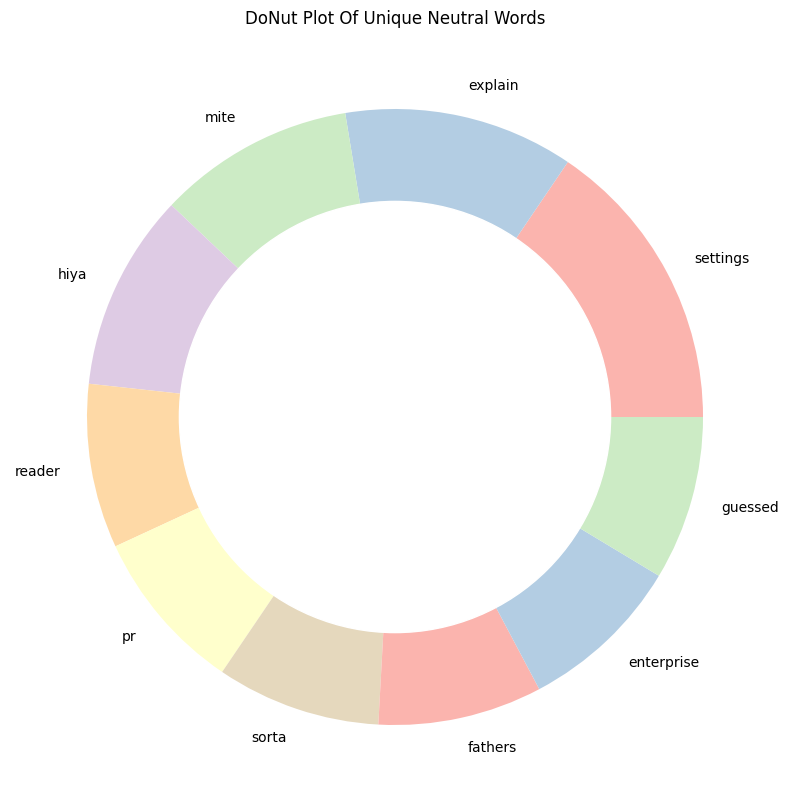

In [ ]:

from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_Neutral['count'], labels=Unique_Neutral.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Neutral Words')
plt.show()

By examining the unique words for each sentiment, we now have a much clearer understanding of the data. These unique words are strong indicators of the sentiment expressed in the tweets.

### Next, Let's Create Word Clouds:
We will build word clouds in the following order:

1. Word Cloud for Neutral Tweets
2. Word Cloud for Positive Tweets
3. Word Cloud for Negative Tweets



In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0, 16.0), color='white',
                   title=None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'u', "im"}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color=color,
                          stopwords=stopwords,
                          max_words=max_words,
                          max_font_size=max_font_size,
                          random_state=42,
                          width=400,
                          height=200,
                          mask=mask)
    wordcloud.generate(str(text))

    plt.figure(figsize=figure_size)
    if image_color and mask is not None:
        image_colors = ImageColorGenerator(mask)
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
        plt.title(title, fontdict={'size': title_size, 'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud)
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 'verticalalignment': 'bottom'})
    plt.axis('off')
    plt.tight_layout()

# Define the paths to your images
comment_mask_path = '/content/comment.png'
loc_mask_path = '/content/loc.png'
star_mask_path = '/content/star.png'
upvote_mask_path = '/content/upvote.png'
user_mask_path = '/content/user.png'

# Load the masks
comment_mask = np.array(Image.open(comment_mask_path))
loc_mask = np.array(Image.open(loc_mask_path))
star_mask = np.array(Image.open(star_mask_path))
upvote_mask = np.array(Image.open(upvote_mask_path))
user_mask = np.array(Image.open(user_mask_path))


# You can similarly plot using other masks
# plot_wordcloud(Neutral_sent.text, mask=loc_mask, color='white', max_font_size=100, title_size=30, title="WordCloud of Neutral Tweets")


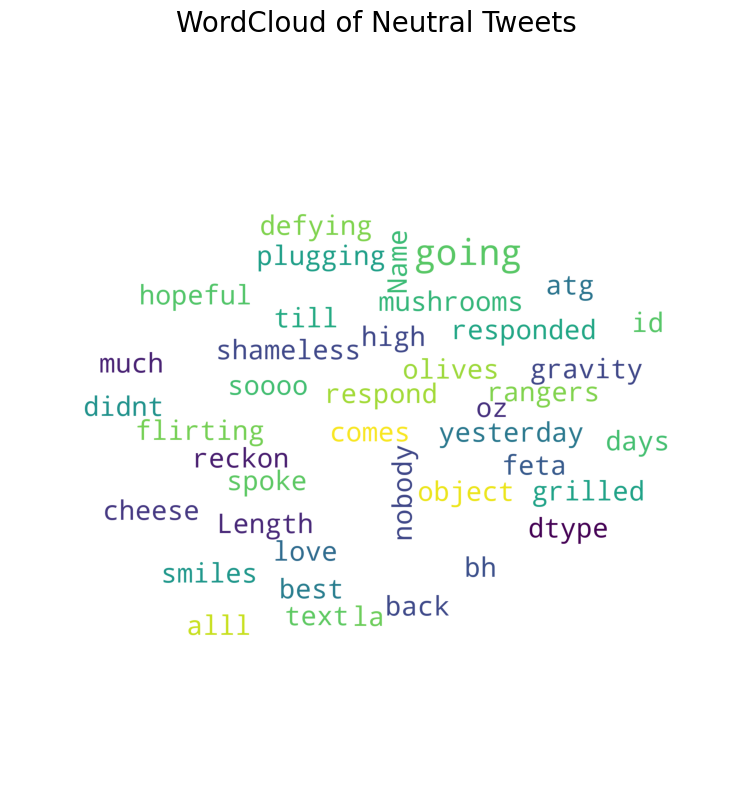

In [ ]:
# Call the plot_wordcloud function with a smaller figure size
plot_wordcloud(
    Neutral_sent.text,             # Text for Neutral tweets
    mask=comment_mask,             # Mask image used for the word cloud
    color='white',                 # Background color of the word cloud
    max_font_size=100,             # Maximum font size in the word cloud
    title_size=20,                 # Reduced title size for better fit
    figure_size=(12.0, 8.0),       # Reduced figure size (width x height)
    title="WordCloud of Neutral Tweets"  # Title of the word cloud
)


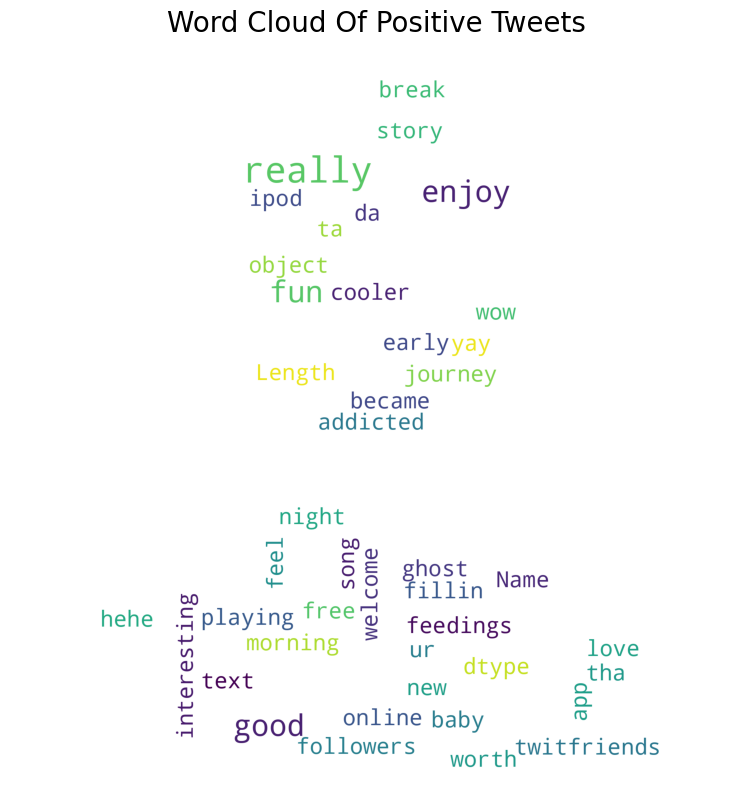

In [ ]:
# Call the plot_wordcloud function with a smaller figure size
plot_wordcloud(
    Positive_sent.text,
    mask=pos_mask,
    title="Word Cloud Of Positive Tweets",
    title_size=20,           # Smaller title size
    figure_size=(12.0, 8.0)  # Smaller figure size (width x height)
)


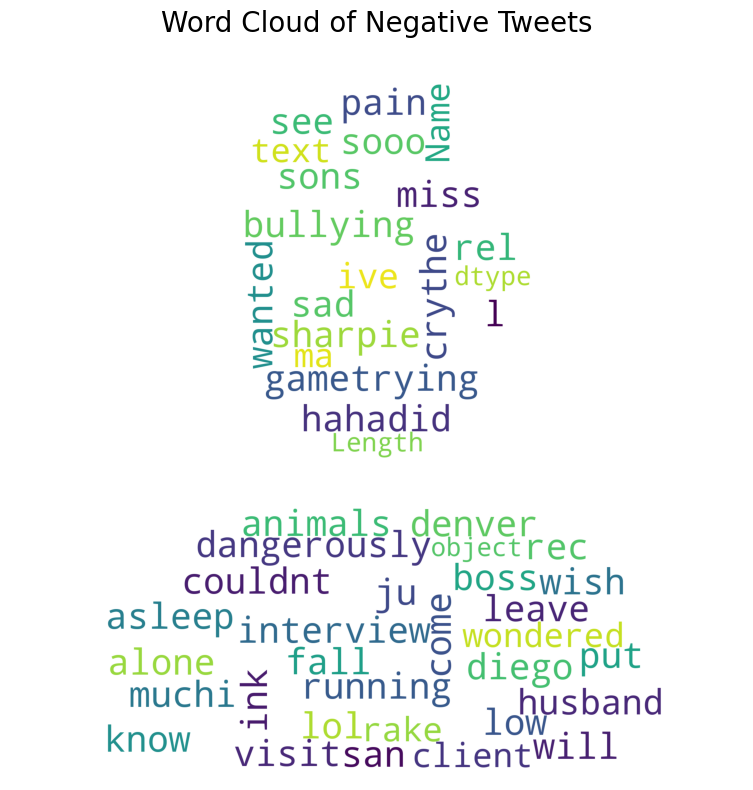

In [ ]:
# Call the plot_wordcloud function with a smaller figure size
plot_wordcloud(
    Negative_sent.text,            # Text for Negative tweets
    mask=pos_mask,                 # Mask image used for the word cloud
    title="Word Cloud of Negative Tweets",  # Title of the word cloud
    color='white',                 # Background color of the word cloud
    title_size=20,                 # Reduced title size for better fit
    figure_size=(12.0, 8.0)        # Reduced figure size (width x height)
)


**Acknowledgment:**

I would like to express my sincere gratitude to [Tanul Singh](https://www.kaggle.com/code/tanulsingh077) for the valuable insights and code provided in the Kaggle notebook, *[Twitter Sentiment Extraction Analysis EDA and Model](https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model)*. This work has been instrumental in guiding and shaping the analysis presented here.

Thank you once again for your contribution to the community.
